# Working with large data
In this extra notebook we want to show how to work with large data files - often several GB large). In such cases the data often wants to occupy more memory than your computer can offer and therefore we need to think about different strategy to tackle such large datasets (especially when working locally on our laptops). 

In this notebook we suggest one way to do so using a library named [VAEX](https://vaex.io/). VAEX is a development on top of Pandas and aims at giving users the same data handling functionality but with less memory-intensive workflows. The idea of VAEX is based on memory mapping using a single memory object and several mappings of it. 

## Download the dataset
To show the power of this library we will take as an example the famous yellow taxi dataset that contains taxi trip data from yellow cabs in New York City in 2019. Execute the command below and wait for the download to begin. This will take several minutes as we download 7.7 GB.

In [3]:
# Download the yellow taxi data file into the data folder.
!curl -L "https://data.cityofnewyork.us/api/views/2upf-qytp/rows.csv?accessType=DOWNLOAD" --output data/yellow_taxi_2019.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7818M    0 7818M    0     0  2147k      0 --:--:--  1:02:08 --:--:-- 2237k-:--  0:01:10 --:--:-- 2174k-:--  0:01:25 --:--:-- 2153k-:--:--  0:02:04 --:--:-- 2172k--:--  0:02:46 --:--:-- 2177k-:--  0:02:50 --:--:-- 2205k:--:--  0:03:31 --:--:-- 2149k  2107k      0 --:--:--  0:04:26 --:--:-- 2106k --:--:--  0:05:19 --:--:-- 2069k:--:--  0:06:36 --:--:-- 2120k-:--  0:07:32 --:--:-- 2160k    0 --:--:--  0:08:09 --:--:-- 2121k    0 --:--:--  0:08:16 --:--:-- 2172k 0  2122k      0 --:--:--  0:08:18 --:--:-- 2155k 2121k      0 --:--:--  0:08:37 --:--:-- 2094k92M    0 1192M    0     0  2123k      0 --:--:--  0:09:35 --:--:-- 2184k--:--:--  0:09:36 --:--:-- 2167k--:--  0:11:16 --:--:-- 2203k:--:--  0:13:56 --:--:-- 2139k--  0:14:17 --:--:-- 2169k    0 --:--:--  0:14:25 --:--:-- 2105k  0     0  2133k      0 --:--:--  0:14:50 --:--:-- 196

## Convert the data

The data is stored as a `CSV` file. __Please do not try to open this file as it will probably lead to problems on your computer because your memory will run full.__ As the same effect would occur when opening this file by either a Python file reader or using Pandas it has to be done in a resourceful way. VAEX offers such a resourceful way by loading it in chunks (we use chunks of around 100,000 rows) and exporting it again in a subfolder in `HDF5` format. [`HDF5`](https://support.hdfgroup.org/HDF5/doc/H5.intro.html) is a data format that gives it already a fast readable structure with many metadata and a hierarchical design. By this I/O access can be managed in parallel and data is already ordered in groups such that certain data can be loaded without touching other. This enables a very fast data access. 

In [1]:
import os, vaex
from tqdm.notebook import tqdm

# Read in the first two lines of data and store the data types
# in a dictionary. 
df_first2 = vaex.from_csv('data/yellow_taxi_2019.csv', nrows = 30)
column_types = {name: (str(dtype.__name__) if isinstance(dtype, type) else 'float64') for name,dtype in df_first2.dtypes.to_dict().items()}

# Create a new directory in the data folder that holds the 
# converted data chunks for further preprocessing.
!mkdir data/yellow_taxi

# Read in the data in memory-firendly chunks. We clean the dataset 
# on-the-fly and remove all entries with more than 6 passengers. 
# Export the data in the data format 'HDF5'.
for i, df in tqdm(enumerate(vaex.from_csv('data/yellow_taxi_2019.csv', chunk_size=100_000, dtype=column_types)), total=844):
    df = df[df.passenger_count < 6]
    df.export_hdf5(f'data/yellow_taxi/taxi_{i:02}.hdf5')
    
# Count the files exported.
print( f"# HDF5 Files in data/yellow_taxi: {len(os.listdir('data/yellow_taxi/'))}")

  0%|          | 0/844 [00:00<?, ?it/s]

# HDF5 Files in data/yellow_taxi: 844


In [2]:
# Check the folder size.
!du -h data/yellow_taxi

 14G	data/yellow_taxi


The exported chunk files occupy now 14 GB of disk space. This is due to the metadata that provides the `HDF5` file structure. And: it is of neglible cost. Disk space is cheap, memory is expensive and the resource to be guarded. However, to use the whole power `HDF5` offers we have to create a single file of this data format. This is done in the next cells. 

In [3]:
# Import all .hdf5 chunks into a single dataset and
# export it to a single .hdf5 file we can work on
df = vaex.open('data/yellow_taxi/taxi*')
df.export_hdf5('data/yellow_taxi_aggregated.hdf5')

# Remove the temporary file directory from the data 
# preprocessing step.
!rm -r data/yellow_taxi

## Reading the data

After the data preprocessing has been done we can finally open the data file and start with the data transformation and analysis. VAEX offers for this the `open()` command that opens an `HDF5`file (without loading it). 

In [4]:
# Open the HDF5 file and show the dimensions
df = vaex.open('data/yellow_taxi_aggregated.hdf5')
print(f'Data dimensions: {df.shape}')

Data dimensions: (82112352, 18)


Over 80 mio. entries. This is impressive. Let us have a preview on the data in the next cell. 

In [5]:
# Preview the data
df

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
<i style='opacity: 0.6'>0</i>,1.0,10/08/2019 10:21:25 PM,10/08/2019 10:25:28 PM,1.0,0.8,1.0,N,74.0,74.0,2.0,5.0,0.5,0.5,0.0,0.0,0.3,6.3,0.0
<i style='opacity: 0.6'>1</i>,1.0,10/08/2019 10:55:18 PM,10/08/2019 11:00:27 PM,1.0,0.6,1.0,N,163.0,229.0,1.0,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5
<i style='opacity: 0.6'>2</i>,2.0,10/08/2019 10:18:09 PM,10/08/2019 10:24:52 PM,1.0,1.27,1.0,N,237.0,233.0,1.0,7.0,0.5,0.5,2.0,0.0,0.3,12.8,2.5
<i style='opacity: 0.6'>3</i>,2.0,10/08/2019 10:50:40 PM,10/08/2019 10:59:37 PM,1.0,1.99,1.0,N,161.0,236.0,1.0,9.0,0.5,0.5,1.92,0.0,0.3,14.72,2.5
<i style='opacity: 0.6'>4</i>,2.0,10/08/2019 10:01:03 PM,10/08/2019 10:06:56 PM,1.0,1.24,1.0,N,263.0,43.0,1.0,6.5,0.5,0.5,1.54,0.0,0.3,11.84,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"<i style='opacity: 0.6'>82,112,347</i>",2.0,11/20/2019 01:26:55 PM,11/20/2019 01:38:15 PM,1.0,1.21,1.0,N,141.0,262.0,2.0,8.5,0.0,0.5,0.0,0.0,0.3,11.8,2.5
"<i style='opacity: 0.6'>82,112,348</i>",2.0,11/20/2019 01:42:44 PM,11/20/2019 02:06:35 PM,1.0,2.49,1.0,N,140.0,170.0,1.0,15.5,0.0,0.5,5.64,0.0,0.3,24.44,2.5
"<i style='opacity: 0.6'>82,112,349</i>",2.0,11/20/2019 01:22:12 PM,11/20/2019 01:30:57 PM,2.0,1.5,1.0,N,141.0,239.0,2.0,8.0,0.0,0.5,0.0,0.0,0.3,11.3,2.5
"<i style='opacity: 0.6'>82,112,350</i>",2.0,11/20/2019 01:33:38 PM,11/20/2019 01:38:28 PM,2.0,0.54,1.0,N,239.0,239.0,2.0,5.0,0.0,0.5,0.0,0.0,0.3,8.3,2.5


Why is it so fast? This is due to the fact that it reads in only the HDF5 metadata (i.e. path, data structure, file description, etc.) and not the data itself. Then, displaying the data requires only the first and last 5 rows to be read from disk. VAEX only goes over the entire dataset if needed. 

For a good starting point we always look at the data summaries so let us see how this works with VAEX on a large dataset. 

In [6]:
# Show some summary statistics
# NOTE: Throws probably a warning in regard to
# division by NAN. You can safely neglect this warning.
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
dtype,float64,str,str,float64,float64,float64,str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,82112352,77383763
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4728589
mean,1.636836526129467,--,--,1.4524298731572078,2.9838907417976532,1.0618018833512406,--,163.2548939043909,161.44797838697886,1.2894824033295258,13.288042800066341,1.1005647899356434,0.4950078007752108,2.200762333663193,0.3779436348419175,0.2985924309783753,19.069242853807484,2.194720979128399
std,0.500791,--,--,0.99687,6.744283,0.767485,--,65.970107,70.220914,0.479656,176.771866,1.252932,0.066047,15.866815,1.812629,0.028003,186.614131,0.829998
min,1.0,--,--,0.0,-23.01,1.0,--,1.0,1.0,1.0,-1856.0,-60.0,-0.5,-221.0,-70.0,-0.3,-1871.8,-2.5
max,4.0,--,--,5.0,45977.22,99.0,--,265.0,265.0,5.0,943274.8,535.38,212.42,141492.02,3288.0,1.0,1084772.17,3.0


All of these stats are calculated in a single pass over the data. This illustrates nicely how efficiently VAEX works. Other libraries would have needed more computing resources while VAEX you need only a few RAM to run this operation. 

## Data manipulations
We can see here a number of different variables, altogether 38, for taxi trips in NYC 2019. Quite often we want to filter the dataset for certain groups of values. Here for example we might want to filter the dataset by the number of passengers:

In [7]:
# Filter the dataset for entries with certain passenger counts and
# display a preview.
df_filtered = df[(df.passenger_count > 0) & (df.passenger_count < 5)]
df_filtered

#,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
<i style='opacity: 0.6'>0</i>,1.0,10/08/2019 10:21:25 PM,10/08/2019 10:25:28 PM,1.0,0.8,1.0,N,74.0,74.0,2.0,5.0,0.5,0.5,0.0,0.0,0.3,6.3,0.0
<i style='opacity: 0.6'>1</i>,1.0,10/08/2019 10:55:18 PM,10/08/2019 11:00:27 PM,1.0,0.6,1.0,N,163.0,229.0,1.0,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5
<i style='opacity: 0.6'>2</i>,2.0,10/08/2019 10:18:09 PM,10/08/2019 10:24:52 PM,1.0,1.27,1.0,N,237.0,233.0,1.0,7.0,0.5,0.5,2.0,0.0,0.3,12.8,2.5
<i style='opacity: 0.6'>3</i>,2.0,10/08/2019 10:50:40 PM,10/08/2019 10:59:37 PM,1.0,1.99,1.0,N,161.0,236.0,1.0,9.0,0.5,0.5,1.92,0.0,0.3,14.72,2.5
<i style='opacity: 0.6'>4</i>,2.0,10/08/2019 10:01:03 PM,10/08/2019 10:06:56 PM,1.0,1.24,1.0,N,263.0,43.0,1.0,6.5,0.5,0.5,1.54,0.0,0.3,11.84,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"<i style='opacity: 0.6'>77,188,337</i>",2.0,11/20/2019 01:26:55 PM,11/20/2019 01:38:15 PM,1.0,1.21,1.0,N,141.0,262.0,2.0,8.5,0.0,0.5,0.0,0.0,0.3,11.8,2.5
"<i style='opacity: 0.6'>77,188,338</i>",2.0,11/20/2019 01:42:44 PM,11/20/2019 02:06:35 PM,1.0,2.49,1.0,N,140.0,170.0,1.0,15.5,0.0,0.5,5.64,0.0,0.3,24.44,2.5
"<i style='opacity: 0.6'>77,188,339</i>",2.0,11/20/2019 01:22:12 PM,11/20/2019 01:30:57 PM,2.0,1.5,1.0,N,141.0,239.0,2.0,8.0,0.0,0.5,0.0,0.0,0.3,11.3,2.5
"<i style='opacity: 0.6'>77,188,340</i>",2.0,11/20/2019 01:33:38 PM,11/20/2019 01:38:28 PM,2.0,0.54,1.0,N,239.0,239.0,2.0,5.0,0.0,0.5,0.0,0.0,0.3,8.3,2.5


Why does this work so fast when we actually have over 80 mio. entries in the data set? 

> It does so, because VAEX has a zero-memory policy,

i.e. filtering the data does not create a copy of it but simply a mapping. `df_filtered` takes no extra memory, instead it is a [shallow copy](https://stackoverflow.com/questions/184710/what-is-the-difference-between-a-deep-copy-and-a-shallow-copy). So instead copying the data and creating an object holding the filtered data, VAEX creates a binary mask applied to the original data. As a comparison: one needs around 1.2GB memory to filter an 80 billion row dataset that might take around 100 GB on disk. Other libraries will have to use another 100GB of memory for the filtered copy. 

### Transforming data

If we transform data, we usually operate on the columns and create new ones. Again, if we do this we create usually more data objects (e.g. Pandas Series) to hold the transformed data. If we have like here >80 mio. entries this is a signficant increase in memory needed. To avoid this VAEX follows its zero-memory policy and works with socalled virtual columns. Virtual columns work as follows: if we create a column from some others in the dataframe VAEX simply stores the expression and evaluates it on-the-fly, if the column is needed. This policy is called [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation#:~:text=In%20programming%20language%20theory%2C%20lazy,avoids%20repeated%20evaluations%20(sharing).). 

In [8]:
# Create a new column with percentage values
df['tip_percentage'] = df.tip_amount / df.total_amount * 100
df.tip_percentage

Expression = tip_percentage
Length: 82,112,352 dtype: float64 (column)
------------------------------------------
       0        0
       1  16.5919
       2   15.625
       3  13.0435
       4  13.0068
       ...       
82112347        0
82112348  23.0769
82112349        0
82112350        0
82112351  16.6667

In [9]:
# Show the new column in a group
df[['fare_amount', 'total_amount', 'tip_amount', 'tip_percentage']].head(5)

#,fare_amount,total_amount,tip_amount,tip_percentage
<i style='opacity: 0.6'>0</i>,5,6.3,0,0
<i style='opacity: 0.6'>1</i>,5.5,11.15,1.85,16.5919
<i style='opacity: 0.6'>2</i>,7,12.8,2,15.625
<i style='opacity: 0.6'>3</i>,9,14.72,1.92,13.0435
<i style='opacity: 0.6'>4</i>,6.5,11.84,1.54,13.0068


The evaluation of such virtual columns in VAEX is blazingly fast as it is written in `C++` and works parallel in core. In the same way aggregation functions and other operands work quite fast in VAEX. We consider an example where we want to the count the trips that have taken place during the year 2019 with certain passenger numbers. 

In [10]:
# Count the number of trips in each passenger number group.
df.passenger_count.value_counts(progress='widget')

1.0    59108834
2.0    12785787
3.0     3583919
5.0     3398212
4.0     1709802
0.0     1525798
dtype: int64

In the following we show a functionality to plot large data using [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/introduction.html) together with VAEX.

[#################-----------------------] 100.00% elapsed time  :     0.20s =  0.0m =  0.0h
 

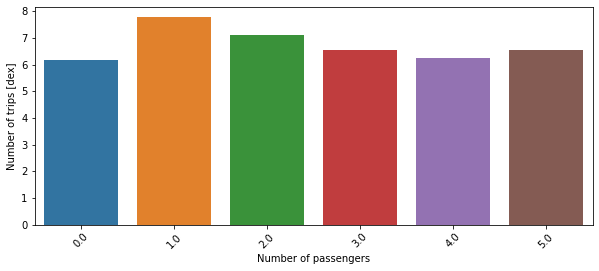

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the number of unique trips with different amount of passnegers
passengers_num = df.passenger_count.value_counts(progress=True)

# Plot the results in a bar chart.
plt.figure(figsize=(10,4))
sns.barplot(x=passengers_num.index, y=np.log10(passengers_num.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

Now, you have some insight in how to work with large data files (often larger than your memory). Check out the [VAEX API](https://vaex.readthedocs.io/en/latest/api.html) and read through the documentation to learn more. 